In [1]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)

    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    d = (state_space[n-1] - state_space[0]) / (n - 1)

    transition_matrix = np.zeros((n, n))
    for i in range(n): # today state
        for j in range(n): # tomorrow state
            if j == 0: # prob going to the lower limit
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # prob going to the upper limit
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # the lower bound
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # the higher bound
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low)

    return transition_matrix, state_space

In [9]:
import numpy as np

def setPar(
    sigma = 1.50, # risk aversion
    beta = 0.98, # subjective discount factor
    delta = 0.03, # depreciation
    alpha = 0.25, # capital’s share of income
    rho = 0.6, # labor productivity persistence
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NH = 2, # number of grids of h
    NA = 401, # number of grids of a
    tau = 0.05, # 資本所得税率
    ):

    # labor productivity variance.
    sigma_eps = np.sqrt(0.6*(1-rho**2))

    # making grids for ln h and solving for income transition probability using Tauchen's method.
    pi, h = tauchen(NH, -0.7, rho, sigma_eps)
    h = np.exp(h) # changing ln h grids to h grids

    # derive the stationary distribution from income transition process

    probst = np.ones((NH))/NH # setting the guess probability to a uniform distribution
    test = 10.0 # initialize the distance to a big number

    while test > 1e-8: # loop until convergence of the stationary distribution
        probst_new = np.zeros((NH)) # initialize new distribution
        for ih in range(NH): # today h
            for ihp in range(NH): # tomorrow h
                probst_new[ihp] += pi[ih, ihp]*probst[ih]

        test = np.max(np.abs(probst_new - probst)) # calculate the difference between the guess and the new distribution
        probst = probst_new # updating the guess

    HH = np.sum(h*probst) # aggregate effective labor

	  # create dictionary with parameters
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH; param['tau'] = tau;

    return param

In [10]:
def solve_household_gs(param, r, w, KK, Tk):

    # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH']; tau = param['tau']

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 - tau)*(1.0 + r)*a[ia] - a[iap] + Tk
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 - tau)*(1.0 + r)*a[ia] - aplus[ia, ih] + Tk

    return aplus, iaplus, c, Tk

In [11]:
def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    mu = np.ones((NA, NH)) / NA / NH # Initialize the distribution mu to be uniform

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        mu_new = np.zeros((NA, NH)) # Initialize a new distribution mu_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update mu_new using the interpolation indices, blending coefficients, and probabilities
                    mu_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * mu[ia, ih]
        test = np.max(np.abs(mu_new - mu)) # Calculate the maximum difference between mu_new and mu
        mu = mu_new # Update mu to be mu_new

    return mu

In [12]:
def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']
    tau = param['tau']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # calculate rental rate of capital and w from firm FOC
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta
        w = (1-alpha) * KK**(alpha) * HH**(-alpha)

        # 資本所得税の総額
        Tk = tau * (1+r) * KK

        decisions = solve_household_gs(param, r, w, KK, Tk)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu, Tk

In [13]:
import matplotlib.pyplot as plt

param = setPar()
(decisions, r, w, KK, HH, mu, Tk) = model_solution(param)

ITERATING ON KK

  metric    Kold      Knew
['0.9235', '10.0000', '0.7650']
['0.8908', '8.1530', '0.8901']
['0.8478', '6.7004', '1.0197']
['0.7852', '5.5643', '1.1954']
['0.6939', '4.6905', '1.4356']
['0.5682', '4.0395', '1.7444']
['0.3867', '3.5805', '2.1960']
['0.1667', '3.3036', '2.7527']
['0.0131', '3.1934', '3.1517']
['0.0023', '3.1851', '3.1777']
['0.0006', '3.1836', '3.1817']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

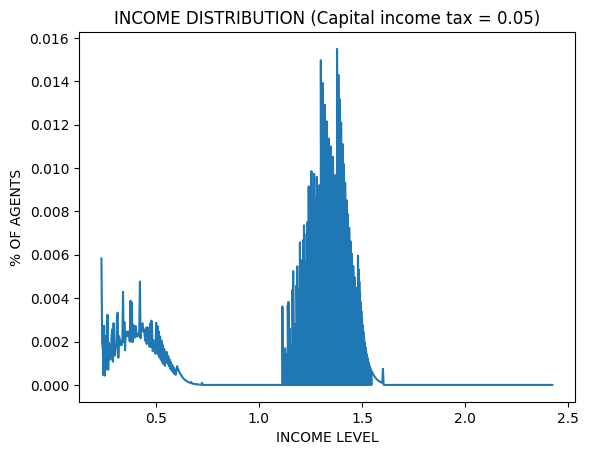

In [14]:
h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
a = np.linspace(a_l, a_u, NA); tau = param['tau'];

# calculate income distribution for each grid
income = np.array([(r*a + w*h[0]), (r*a + w*h[1])])
# # transpose income
income = income.T
# # sorting the income after flattening "income"
# pinc, index = np.sort(income.flatten('F')), np.argsort(income.flatten('F'))
# plambda = mu.flatten('F')
# #

# sort with regard to the 1st argument of zip
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title(f'INCOME DISTRIBUTION (Capital income tax = {tau})')
plt.xlabel('INCOME LEVEL')
plt.ylabel('% OF AGENTS')

from google.colab import files
plt.savefig(f'income_distribution_tax={tau}.png')
files.download(f'income_distribution_tax={tau}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

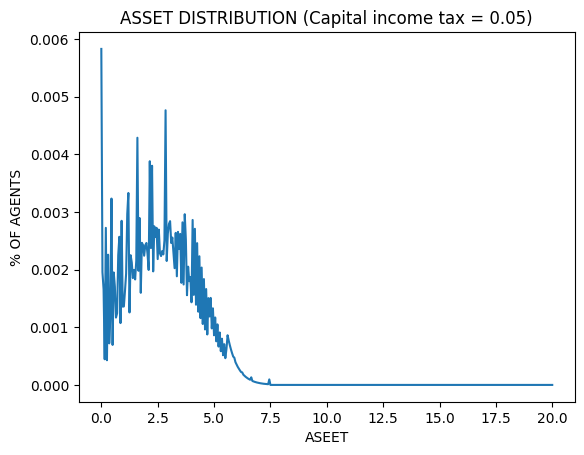

In [15]:
h = param['h']
a_l = param['a_l']; a_u = param['a_u']; NA = param['NA'];
a = np.linspace(a_l, a_u, NA); tau = param['tau'];

# sort with regard to the 1st argument of zip
zip_lists = zip(a.flatten('F'), mu.flatten('F'))
# sort upwards
zip_sort = sorted(zip_lists)
# unzip
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title(f'ASSET DISTRIBUTION (Capital income tax = {tau})')
plt.xlabel('ASEET')
plt.ylabel('% OF AGENTS')

from google.colab import files
plt.savefig(f'asset_distribution_tax={tau}.png')
files.download(f'asset_distribution_tax={tau}.png')